In [14]:
# IMPORTS
import pandas as pd
import os
import yfinance as yf
import seaborn as sns  # Used this library because it is most efficient for KDE charts
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick # To convert x axis on plots to percentage return
import numpy as np
import time
from scipy.stats import gaussian_kde # To extract peak KDE for visualizations (not currently used)

In [15]:
# LOAD PRIOR CSV DATA FILE

# Read it (update filename as needed)
df = pd.read_csv("notebook3_added_price_data.csv")

In [16]:
# CREATE NEW UPDATED CSV DATA FILE
# Add a new column indicating if the insider's purchase price was within the day's trading range
df["price_within_day_range"] = df.apply(
    lambda row: (
        row["transactiondate_low"] <= row["price_per_share"] <= row["transactiondate_high"]
        if pd.notnull(row["transactiondate_low"]) and pd.notnull(row["transactiondate_high"]) and pd.notnull(row["price_per_share"])
        else None
    ),
    axis=1 # 1 means apply across rows
)

# APPLY FILTERS TO DATA
# Filter out rows where the insider’s purchase price did not fall within the stock’s high/low price range on the transaction date
df_cleaned = df[df["price_within_day_range"] == True].copy()

# Filter out transactions where total capital invested < $10,000
df_cleaned = df_cleaned[df_cleaned["total_capital"] >= 10000].copy()

# CALCULATE RETURNS
# Calculate 6-month return for each trade
df_cleaned["return_6month"] = (df_cleaned["price_6month"] - df_cleaned["average_price_per_share"]) / df_cleaned["average_price_per_share"]

# Calculate SPY return and excess return
df_cleaned["spy_return_6month"] = (
    (df_cleaned["spy_price_6month"] - df_cleaned["spy_price_transactiondate"]) / df_cleaned["spy_price_transactiondate"]
)
df_cleaned["excess_return_6month"] = df_cleaned["return_6month"] - df_cleaned["spy_return_6month"]



In [17]:

# ADD BETA FROM YFINANCE (can add Sector data later)
# Extract unique tickers AFTER filtering to reduce API calls
unique_tickers = df_cleaned["Ticker"].dropna().unique()

cache_file = "ticker_metadata_cache.csv"

# Load cache if it exists
if os.path.exists(cache_file):
    cache_df = pd.read_csv(cache_file)
    ticker_to_beta = dict(zip(cache_df["Ticker"], cache_df["beta"]))
    ticker_to_sector = dict(zip(cache_df["Ticker"], cache_df["sector"]))
else:
    cache_df = pd.DataFrame(columns=["Ticker", "beta"])
    ticker_to_beta = {}
    ticker_to_sector = {}

# Identify tickers not already cached
tickers_to_query = [ticker for ticker in unique_tickers if ticker not in ticker_to_beta]

# Progress summary check
print("Total unique tickers after filtering:", len(unique_tickers))
print("Tickers requested from yfinance:", len(tickers_to_query))


# FUNCTION TO GET BETA AND SECTOR FROM YFINANCE (copied from Notebook 4, which was developed by Rami)
def get_company_info(ticker):
    try:
        cleaned_ticker = ticker.replace(".", "-")
        info = yf.Ticker(cleaned_ticker).info
        beta = info.get("beta", None)
        sector = info.get("sector", None)
        return beta, sector
    except:
        return None, None

# LOOP OVER TICKERS TO GET DATA
new_rows = []
for ticker in tickers_to_query:
    beta, sector = get_company_info(ticker)
    ticker_to_beta[ticker] = beta
    ticker_to_sector[ticker] = sector
    new_rows.append({"Ticker": ticker, "beta": beta, "sector": sector})
    time.sleep(0.5)

# UPDATE CACHE
if new_rows:
    cache_df = pd.concat([cache_df, pd.DataFrame(new_rows)], ignore_index=True)
    cache_df.to_csv(cache_file, index=False)

# MAP ENRICHED DATA BACK TO df_cleaned
df_cleaned["beta"] = df_cleaned["Ticker"].map(ticker_to_beta)
df_cleaned["sector"] = df_cleaned["Ticker"].map(ticker_to_sector)

# SAVE FINAL OUTPUT TO CSV
df_cleaned.to_csv("notebook6_data.csv", index=False)
print("Saved updated file: notebook6_data.csv")



Total unique tickers after filtering: 1656
Tickers requested from yfinance: 1656


C:\Users\tmacp\AppData\Local\Temp\ipykernel_28332\3834017568.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cache_df = pd.concat([cache_df, pd.DataFrame(new_rows)], ignore_index=True)


Saved updated file: notebook6_data.csv


In [5]:
# CALCULATE BETA-ADJUSTED RETURN AND DEFINE ELITE ALPHA INSIDERS
# Calculate beta-adjusted excess return
df_cleaned["beta_adj_excess_return"] = df_cleaned.apply(
    lambda row: row["excess_return_6month"] / row["beta"]
    if pd.notnull(row["beta"]) and row["beta"] != 0 else None,
    axis=1
)

# Separate all trades into positive and negative groups based on excess return threshold
df_cleaned_positive_excess = df_cleaned[df_cleaned["excess_return_6month"] >= 0.20].copy()
df_cleaned_negative_excess = df_cleaned[df_cleaned["excess_return_6month"] <= -0.20].copy()

# Define elite alpha insiders (3 or more buys with >=20% excess return)
df_elite_alpha_insiders = (
    df_cleaned_positive_excess
    .groupby("Insider Name")
    .filter(lambda x: len(x) >= 3)
    .copy()
)

# Select relevant columns for export or display
columns_to_include = [
    "Insider Name", "Insider Title", "Insider Role", "Issuer", "Ticker", "CIK Code",
    "Period of Report", "Transaction Date", "Security", "Ownership Type",
    "ACCESSION_NUMBER", "shares", "price_per_share", "shares_after",
    "return_6month", "spy_return_6month", "excess_return_6month",
    "beta", "beta_adj_excess_return", "sector"
]

# # Check (Uncomment to view)
# print(df_cleaned_positive_excess.columns)



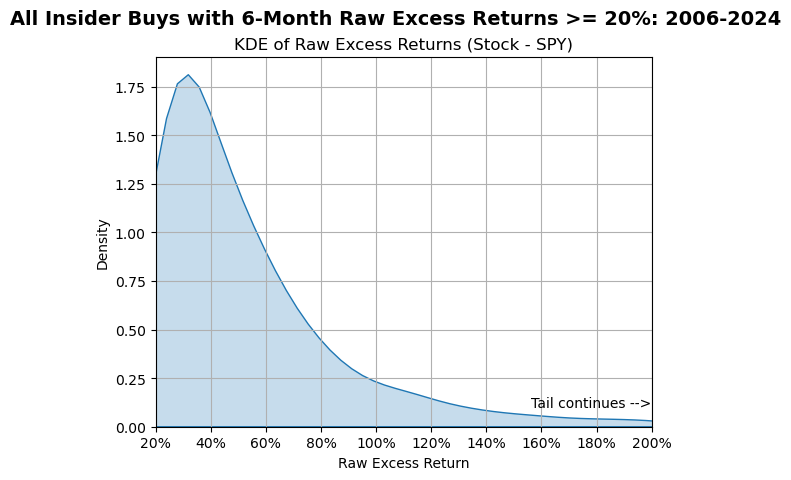

In [6]:
# # Sanity check that min excess return is >= 20% (uncomment to view)
# print("Min excess return 6-month", df_cleaned_positive_excess["excess_return_6month"].min())

# PLOT 1: KDE of All Raw Excess Return Buys (Stock - SPY)
# Note: Clipped KDE on left tail to show only actual data (don't smooth below zero)
sns.kdeplot(data=df_cleaned_positive_excess,
            x="excess_return_6month",
            fill=True,
            clip=(0.2, None))

# Titles
plt.suptitle("All Insider Buys with 6-Month Raw Excess Returns >= 20%: 2006-2024", fontsize=14, fontweight="bold")
plt.title("KDE of Raw Excess Returns (Stock - SPY)", fontsize=12)

# Labels and formatting
plt.xlabel("Raw Excess Return")
plt.ylabel("Density")

# Clip x axis
plt.xlim(0.2, 2)
plt.annotate("Tail continues -->", xy=(2, 0.1), fontsize=10, ha="right")

# Format x axis as percentage
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

plt.grid(True)
plt.show()


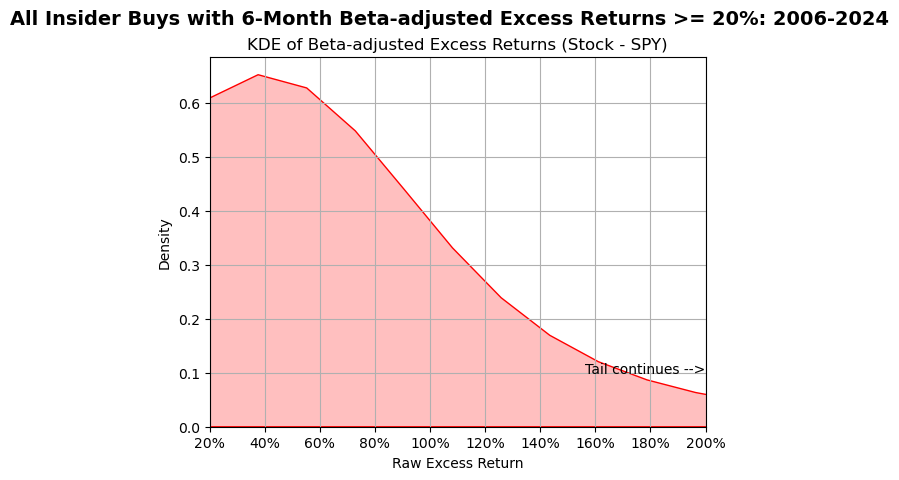

In [7]:
# PLOT 2: KDE of All Beta-adjusted Excess Return Buys (Stock - SPY)
# Define df_cleaned_pos_beta_adj
df_cleaned_pos_beta_adj = df_cleaned[
    (df_cleaned["excess_return_6month"] >= 0.20) &
    (df_cleaned["beta"].notnull()) &
    (df_cleaned["beta"] != 0)
].copy()

# Calculate beta_adjusted return
df_cleaned_pos_beta_adj["beta_adj_excess_return"] = (
    df_cleaned_pos_beta_adj["excess_return_6month"] / df_cleaned_pos_beta_adj["beta"]
)


# Note: Clipped KDE on left tail to show only actual data (don't smooth below zero)
sns.kdeplot(data=df_cleaned_pos_beta_adj,
            x="beta_adj_excess_return",
            fill=True,
            color="red",
            clip=(0.2, None)

            )
plt.suptitle("All Insider Buys with 6-Month Beta-adjusted Excess Returns >= 20%: 2006-2024", fontsize=14, fontweight="bold")
plt.title("KDE of Beta-adjusted Excess Returns (Stock - SPY)", fontsize=12)

# Labels and formatting
plt.xlabel("Raw Excess Return")
plt.ylabel("Density")

# Clip x axis
plt.xlim(0.2, 2)
plt.annotate("Tail continues -->", xy=(2, 0.1), fontsize=10, ha="right")

# Format x axis as percentage
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

plt.grid(True)
plt.show()

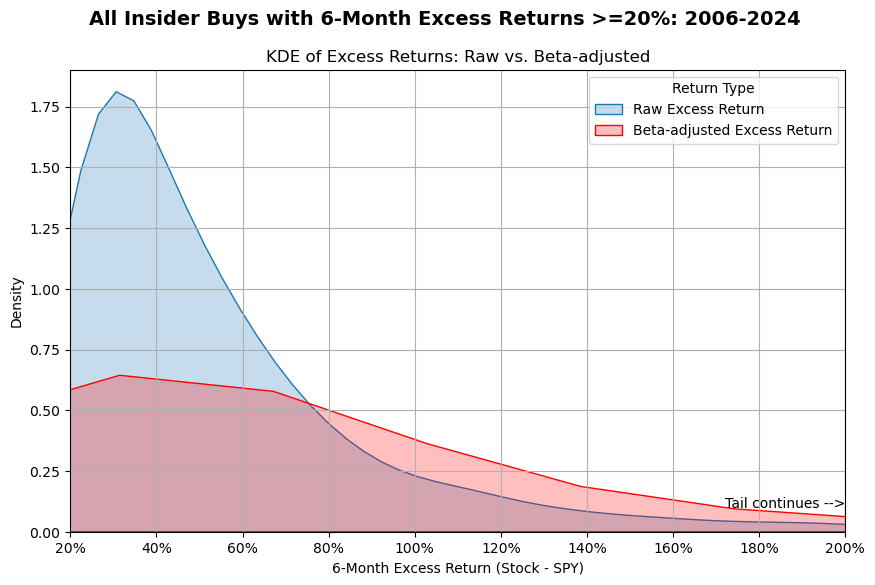

In [8]:
# PLOT 3: Compare Raw and Beta-adjusted excess returns in one chart
plt.figure(figsize=(10, 6))

sns.kdeplot(data=df_cleaned_positive_excess,
            x="excess_return_6month",
            fill=True,
            label="Raw Excess Return",
            common_norm=False # Normalizes each KDE independently
            )

sns.kdeplot(data=df_cleaned_pos_beta_adj,
            x="beta_adj_excess_return",
            fill=True,
            color="red",
            label="Beta-adjusted Excess Return",
            common_norm=False # Normalizes each KDE independently
            )

# Titles and labels
plt.suptitle("All Insider Buys with 6-Month Excess Returns >=20%: 2006-2024", fontsize=14, fontweight="bold")
plt.title("KDE of Excess Returns: Raw vs. Beta-adjusted", fontsize=12)

# Labels and formatting
plt.xlabel("6-Month Excess Return (Stock - SPY)")
plt.ylabel("Density")
plt.legend(title="Return Type")

# Clip x axis
plt.xlim(0.2, 2)
plt.annotate("Tail continues -->", xy=(2, 0.1), fontsize=10, ha="right")

# Format x axis as percentage
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

plt.grid(True)
plt.show()

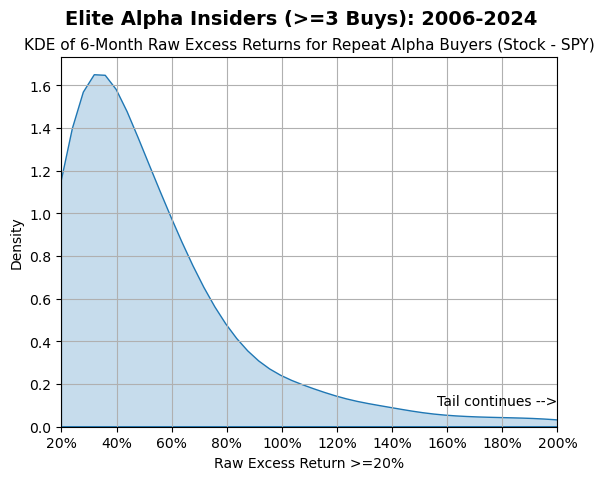

In [9]:
# PLOT 4: Elite Alpha Insiders: Raw Excess Returns
# Insiders with >=3 Buys with Raw Excess Returns >=20%
# Note: Clipped KDE on left tail to show only actual data (don't smooth below zero)
sns.kdeplot(data=df_elite_alpha_insiders,
            x="excess_return_6month",
            fill=True,
            clip=(0.2, None))

# Titles
plt.suptitle("Elite Alpha Insiders (>=3 Buys): 2006-2024", fontsize=14, fontweight="bold")
plt.title("KDE of 6-Month Raw Excess Returns for Repeat Alpha Buyers (Stock - SPY)", fontsize=11)

# Labels and formatting
plt.xlabel("Raw Excess Return >=20%")
plt.ylabel("Density")

# Clip x axis
plt.xlim(0.2, 2)
plt.annotate("Tail continues -->", xy=(2, 0.1), fontsize=10, ha="right")

# Format x axis as percentage
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

plt.grid(True)
plt.show()


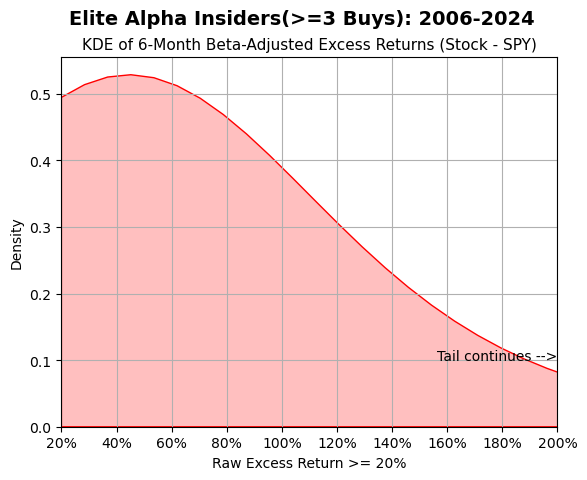

In [10]:
# PLOT 5: Elite Alpha Insiders: Beta-adjusted Excess Returns
# Insiders with >=3 Buys with Beta-adjusted Excess Returns >=20%

# # Check (uncomment to view)
# print("Preview values:")
# print(df_elite_alpha_insiders["beta_adj_excess_return"].dropna().head())

# Filter and create temporary DataFrame for valid beta values
df_elite_alpha_insiders_valid = df_elite_alpha_insiders[
    df_elite_alpha_insiders['beta'].notnull() & df_elite_alpha_insiders['beta'] != 0
].copy()

# Calculate beta-adjusted excess return
df_elite_alpha_insiders_valid["beta_adj_excess_return"] = (
    df_elite_alpha_insiders_valid["excess_return_6month"] / df_elite_alpha_insiders_valid["beta"]
)

# Plot KDE
# Note: Clipped KDE on left tail to show only actual data (don't smooth below zero)
sns.kdeplot(data=df_elite_alpha_insiders_valid,
            x="beta_adj_excess_return",
            fill=True,
            color="red",
            clip=(0.2, None),
            warn_singular=False)

# Titles
plt.suptitle("Elite Alpha Insiders(>=3 Buys): 2006-2024", fontsize=14, fontweight="bold")
plt.title("KDE of 6-Month Beta-Adjusted Excess Returns (Stock - SPY)", fontsize=11)

# Labels and formatting
plt.xlabel("Raw Excess Return >= 20%")
plt.ylabel("Density")

# Clip x axis
plt.xlim(0.2, 2)
plt.annotate("Tail continues -->", xy=(2, 0.1), fontsize=10, ha="right")

# Format x axis as percentage
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

plt.grid(True)
plt.show()


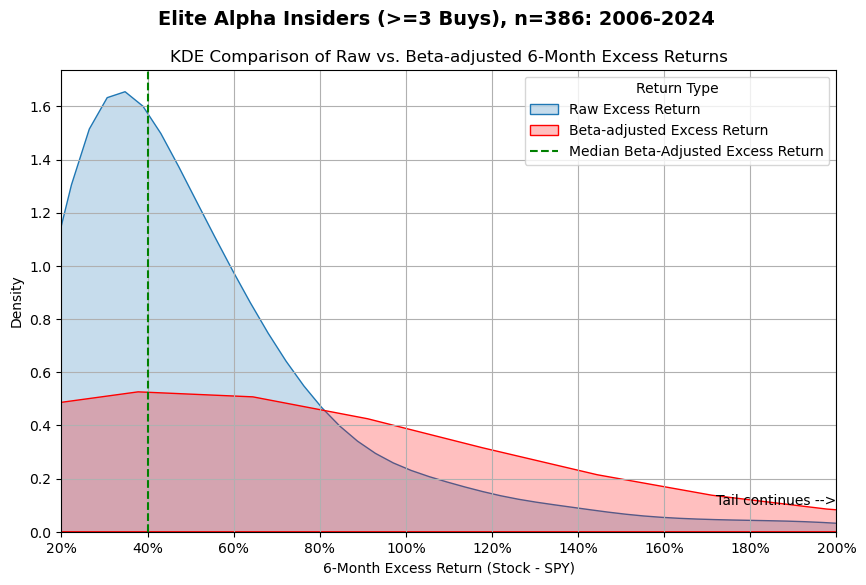

In [11]:
# PLOT 6: Elite Alpha Insiders: Compare Raw vs. Beta-adjusted returns in one chart
# Count unique number of elite alpha insiders
num_elite_alpha_insiders = df_elite_alpha_insiders["Insider Name"].nunique()

# Calculate median beta-adjusted excess return from valid subset
median_beta_adj_excess_return = df_elite_alpha_insiders_valid["beta_adj_excess_return"].median()


plt.figure(figsize=(10, 6))

# Raw excess return KDE
sns.kdeplot(data=df_elite_alpha_insiders,
            x="excess_return_6month",
            fill=True,
            label="Raw Excess Return",
            warn_singular=False,
            common_norm=False) # Normalizes each KDE independently


# Beta-adjusted excess return KDE
sns.kdeplot(data=df_elite_alpha_insiders_valid,
            x="beta_adj_excess_return",
            fill=True,color="red",
            label="Beta-adjusted Excess Return",
            warn_singular=False,
            common_norm=False) # Normalizes each KDE independently

# Add vertical line for median
plt.axvline(x=median_beta_adj_excess_return, color="green", linestyle="--", label="Median Beta-Adjusted Excess Return")


# Titles and labels
plt.suptitle(f"Elite Alpha Insiders (>=3 Buys), n={num_elite_alpha_insiders}: 2006-2024", fontsize=14, fontweight="bold")
plt.title("KDE Comparison of Raw vs. Beta-adjusted 6-Month Excess Returns", fontsize=12)

# Labels and formatting
plt.xlabel("6-Month Excess Return (Stock - SPY)")
plt.ylabel("Density")
plt.legend(title="Return Type")

# Clip x axis
plt.xlim(0.2, 2)
plt.annotate("Tail continues -->", xy=(2, 0.1), fontsize=10, ha="right")

# Format x axis as percentage
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

plt.grid(True)
plt.show()

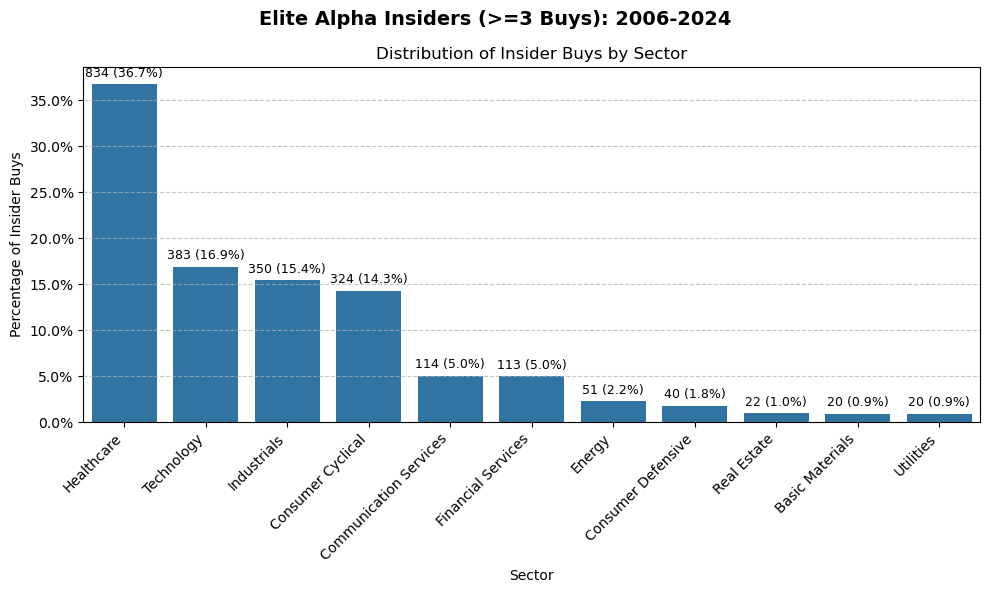

In [12]:
# PLOT 7: Sector distribution of Elite Alpha Insiders (>=3 Buys)

# Filter and create temporary DataFrame for valid sector values
df_elite_alpha_sector_valid = df_elite_alpha_insiders[df_elite_alpha_insiders["sector"].notnull()].copy()

# Calculate sector counts and percentages
sector_counts = df_elite_alpha_sector_valid["sector"].value_counts()
sector_percentages = (sector_counts / sector_counts.sum()) * 100

# Plot bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=sector_counts.index, y=sector_percentages.values)

# Titles
plt.suptitle("Elite Alpha Insiders (>=3 Buys): 2006-2024", fontsize=14, fontweight="bold")
plt.title("Distribution of Insider Buys by Sector", fontsize=12)

# Labels and formatting
plt.xlabel("Sector")
plt.ylabel("Percentage of Insider Buys")
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

# Annotate bars with count and percentage
for i, (count, pct) in enumerate(zip(sector_counts.values, sector_percentages.values)):
  ax.text(i, pct + 0.5, f"{count} ({pct:.1f}%)", ha="center", va="bottom", fontsize=9)

# Grid and layout
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

plt.show()

